In [1]:
""" Molecular Dynamics Simulation (Object-Oriented Version)
This code simulates the dynamics of atoms governed by the Lennard-Jones and spring potential at the atomic and molecular scale.
Authors: Borui Xu, Lucien Tsai, Yeqi Chu
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
from typing import List, Tuple, Optional, Set, Dict

class Atom:
    """An abstract base class for an individual atom."""
    def __init__(
        self, 
        position: np.ndarray, 
        velocity: np.ndarray,
        mass: float, 
        epsilon: float, 
        sigma: float) -> None:
        
        self.position: np.ndarray = np.array(position, dtype=float)
        self.velocity: np.ndarray = np.array(velocity, dtype=float)
        self.mass: float = mass
        self.epsilon: float = epsilon
        self.sigma: float = sigma
        self.force: np.ndarray = np.zeros(3, dtype=float)
        
class Potential(ABC):
    """An abstract base class for the different potentials."""
    def __init__(self, pairwise_interactions: Optional[Set[Tuple[int, int]]] = None) -> None:
        """
        Args:
            pairwise_interactions: Optional set of (i, j) tuples that define interacting atom pairs. If None, all atom pairs interact.
                                   
            Note: Include both (i,j) and (j,i).
        """
        self.pairwise_interactions = pairwise_interactions

    @abstractmethod
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        """Computes the forces acting on all atoms."""
        pass
    
class Constraint(ABC):
    """An abstract base class for the constraints."""
    @abstractmethod
    def apply(self, atoms: List[Atom], box_size: float) -> None:
        """Enforces constraints on the relevant atoms."""
        pass
        
class LennardJonesPotential(Potential):
    """A concrete class for the Lennard-Jones potential."""
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        for atom in atoms:
            atom.force.fill(0.0)  # Set all forces to 0

        num_atoms: int = len(atoms)
        for i in range(num_atoms):
            atom_i: Atom = atoms[i]
            for j in range(num_atoms):
                if i == j:  # Skip self-interaction
                    continue

                # Check if (i, j) is included in a pairwise interaction
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue

                atom_j: Atom = atoms[j]
                delta: np.ndarray = atom_i.position - atom_j.position
                # Apply Periodic Boundary Conditions
                delta -= box_size * np.round(delta / box_size)
                r: float = float(np.linalg.norm(delta))
                if r == 0:
                    continue
                epsilon_ij: float = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij: float = (atom_i.sigma + atom_j.sigma) / 2
                F_mag: float = 4 * epsilon_ij * (
                    (12 * sigma_ij**12 / r**13) - (6 * sigma_ij**6 / r**7)
                )
                force_vector: np.ndarray = (F_mag / r) * delta
                # Apply Newton's third law
                atom_i.force += force_vector
                atom_j.force -= force_vector
                
class LinearSpringPotential(Potential):
    """A concrete class for the spring potential for a spring with rest length r0."""
    def __init__(
        self, 
        rest_lengths: Dict[Tuple[int, int], float], 
        k: float = 1.0, 
        pairwise_interactions: Optional[Set[Tuple[int, int]]] = None
    ) -> None:
        super().__init__(pairwise_interactions)
        self.rest_lengths = rest_lengths
        self.k = k

    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        for atom in atoms:
            atom.force.fill(0.0)  # Set all forces to 0

        num_atoms = len(atoms)
        for i in range(num_atoms):
            atom_i = atoms[i]
            for j in range(i + 1, num_atoms):
                atom_j = atoms[j]

                # Check if (i, j) is included in a pairwise interaction
                if self.pairwise_interactions is not None:
                    if (i, j) not in self.pairwise_interactions and (j, i) not in self.pairwise_interactions:
                        continue

                # Check if the rest lengths are defined
                if (i, j) in self.rest_lengths:
                    r0 = self.rest_lengths[(i, j)]
                elif (j, i) in self.rest_lengths:
                    r0 = self.rest_lengths[(j, i)]
                else:
                    continue

                delta = atom_i.position - atom_j.position
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                if r == 0:
                    # Skip if the atomic positions are the same
                    continue

                # Compute displacement
                dr = r - r0
                if dr != 0.0:
                    # Compute Force
                    F_mag = self.k * dr
                    # Compute Direction
                    direction = delta / r
                    force_vector = F_mag * direction
                    # Apply Newton's 3rd Law
                    atom_i.force -= force_vector
                    atom_j.force += force_vector

class FixPointConstraint(Constraint):
    """A concrete class for a constraint that fixes certain atoms to a position."""
    def __init__(self, fixed_points: Dict[int, Tuple[float, float, float]]) -> None:
        """
        fixed_points: {atom_index: (x_fixed, y_fixed, z_fixed)} 
        """
        self.fixed_points = fixed_points

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        for idx, atom in enumerate(atoms):
            if idx in self.fixed_points:
                # Set the atomic position to the specified position
                fixed_pos = self.fixed_points[idx]
                atom.position[:] = fixed_pos
                atom.velocity.fill(0.0)
                
class PartialFixConstraint(Constraint):
    """A concrete class for a constraint that fixes certain atoms in specific Cartesian directions.
    
    partial_fixed_points: {atom_index: (x_val, y_val, z_val)}
      - x_val, y_val, z_val can be None or float.
      - If float, that coordinate of the atom is fixed to this value.
      - If None, that coordinate is not constrained.
    """

    def __init__(self, partial_fixed_points: Dict[int, Tuple[Optional[float], Optional[float], Optional[float]]]) -> None:
        self.partial_fixed_points = partial_fixed_points

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        for idx, atom in enumerate(atoms):
            if idx in self.partial_fixed_points:
                x_val, y_val, z_val = self.partial_fixed_points[idx]

                # Constrain x coordinate if specified
                if x_val is not None:
                    atom.position[0] = x_val
                    atom.velocity[0] = 0.0  # Set velocity to zero to prevent conflicting conditions

                # Constrain y coordinate if specified
                if y_val is not None:
                    atom.position[1] = y_val
                    atom.velocity[1] = 0.0  # Set velocity to zero to prevent conflicting conditions

                # Constrain z coordinate if specified
                if z_val is not None:
                    atom.position[2] = z_val
                    atom.velocity[2] = 0.0  # Set velocity to zero to prevent conflicting conditions

class FixedDistanceConstraint(Constraint):
    """A concrete class for a constraint that fixes the distance between certain atom pairs at r0."""
    def __init__(
        self, 
        fixed_distances: Dict[Tuple[int, int], float], 
        pairwise_interactions: Optional[Set[Tuple[int,int]]] = None
    ) -> None:
        """
        fixed_distances: {(i,j): r0} means that the target distance of an atom pair (i,j) is r0. 

            Note: Include both (i,j) and (j,i).

        pairwise_interactions: If given, apply this constraint only to these pairs.
        """
        self.fixed_distances = fixed_distances
        self.pairwise_interactions = pairwise_interactions

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue
                if (i, j) not in self.fixed_distances:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]

                delta = atom_i.position - atom_j.position
                # Apply Periodic Boundary Conditions
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                r0 = self.fixed_distances[(i, j)]

                if r == 0:
                    # Skip if the atomic positions are the same
                    continue

                # Adjust position if r != r0
                if r != r0:
                    excess = r - r0
                    direction = delta / r
                    # Apply equal distribution correction
                    correction = direction * (excess / 2.0)

                    # Adjust the position of the atoms so that the final distance changes back to r0
                    atom_i.position -= correction
                    atom_j.position += correction

                    # The coordinates are modified with Periodic Boundary Conditions
                    atom_i.position %= box_size
                    atom_j.position %= box_size

class MolecularDynamicsSimulator:
    """An abstract base class to perform the simulation."""
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int,
        potential: Potential,
        constraints: Optional[List[Constraint]] = None
    ) -> None:
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.potential = potential
        self.constraints = constraints if constraints is not None else []
        self.all_atom_energy = np.zeros((total_steps + 1, self.num_atoms))
        self.total_energy = np.zeros(total_steps + 1)
        self.all_atom_speed = np.zeros((total_steps + 1, self.num_atoms))

    def integrate(self) -> None:
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces
        self.potential.compute_forces(self.atoms, self.box_size)

        # Perform integration step
        for step in range(1, self.total_steps + 1):
            # Update positions using Verlet Integration
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                atom.position %= self.box_size

            # Apply constraints
            for c in self.constraints:
                c.apply(self.atoms, self.box_size)

            # Compute new forces
            self.potential.compute_forces(self.atoms, self.box_size)

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

            # Initialize arrays for Particle Statistics
            step_atomic_energy = np.zeros(self.num_atoms)  # This energy is kinetic
            step_atomic_speed = np.zeros(self.num_atoms)
            total_step_energy = 0  # This energy is kinetic
            
            # Compute Particle Statistics
            for idx, atom in enumerate(self.atoms):
                atom_speed = np.linalg.norm(atom.velocity)
                atom_energy = 0.5 * atom.mass * atom_speed**2
                step_atomic_energy[idx] = atom_energy
                step_atomic_speed[idx] = atom_speed
                total_step_energy += atom_energy

            self.all_atom_energy[step, :] = step_atomic_energy
            self.all_atom_speed[step, :] = step_atomic_speed
            self.total_energy[step] = total_step_energy

    def animate_positions(self, filename: str = 'simulation.gif', interval: int = 50, save_gif: bool = True,
                          elev: float = 30, azim: float = 60, lj_pairs: Optional[List[Tuple[int, int]]] = None,
                          fixed_pairs: Optional[List[Tuple[int, int]]] = None) -> None:
        """Animates the atom positions in 3D."""
        # Use empty lists if no pairs are provided
        if lj_pairs is None:
            lj_pairs = []
        if fixed_pairs is None:
            fixed_pairs = []
    
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(121, projection='3d')
        ax.set_xlim(0, self.box_size)
        ax.set_ylim(0, self.box_size)
        ax.set_zlim(0, self.box_size)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title('Molecular Dynamics Simulation')
    
        # Initial scatter plot
        frame_positions = self.positions[0]
        scatter_plt = ax.scatter(frame_positions[:, 0], frame_positions[:, 1], frame_positions[:, 2], s=100, c='blue')
    
        def update_positions(frame: int):
            # Update atom positions
            ax.clear()
            ax.set_xlim(0, self.box_size)
            ax.set_ylim(0, self.box_size)
            ax.set_zlim(0, self.box_size)
            ax.view_init(elev=elev, azim=azim)
            ax.set_xlabel('X (Å)')
            ax.set_ylabel('Y (Å)')
            ax.set_zlabel('Z (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')

            # Update scatter plot
            current_positions = self.positions[frame]
            scatter_plt = ax.scatter(current_positions[:, 0], current_positions[:, 1], current_positions[:, 2], s=100, c='blue')
    
            # Draw LJ potential lines (black dashed)
            for (i, j) in lj_pairs:
                xi, yi, zi = current_positions[i]
                xj, yj, zj = current_positions[j]
                ax.plot([xi, xj], [yi, yj], [zi, zj], "k--")
    
            # Draw fixed distance lines (red solid)
            for (i, j) in fixed_pairs:
                xi, yi, zi = current_positions[i]
                xj, yj, zj = current_positions[j]
                ax.plot([xi, xj], [yi, yj], [zi, zj], "r-")
    
            # Return the updated scatter plot
            return scatter_plt
    
        # Create animation
        ani = FuncAnimation(
            fig,
            update_positions,
            frames=range(0, self.total_steps + 1, max(1, self.total_steps // 100)),
            interval=interval,
            blit=False
        )
    
        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()
    
    
    def animate_statistics(self, filename: str = 'energy_speed_hist.gif', interval: int = 50, save_gif: bool = True) -> None:
        """Animates the kinetic energy and velocity distributions."""
        fig = plt.figure(figsize=(12, 8))
        # Create 2D histogram subplots
        ax1 = fig.add_subplot(121)
        ax1.set_xlabel('Energy (eV)')
        ax1.set_ylabel('Number of Atoms')
        ax1.set_title('Kinetic Energy Distribution')
        
        ax2 = fig.add_subplot(122)
        ax2.set_xlabel('Speed (Å/ns)')
        ax2.set_ylabel('Number of Atoms')
        ax2.set_title('Speed Distribution')
    
        # Number of bins for histograms
        energy_bins = 50
        speed_bins = 50
    
        # Initial histograms
        energy_hist = ax1.hist([], bins=energy_bins, range=(np.min(self.all_atom_energy), np.max(self.all_atom_energy)), histtype='step', label='Energy')
        speed_hist = ax2.hist([], bins=speed_bins, range=(0, np.max(self.all_atom_speed)), histtype='step', label='Speed')
    
        def update_statistics(frame: int):
            # Update kinetic energy histogram
            energy_data = np.array(self.all_atom_energy[frame])  # Current kinetic energy
            ax1.clear()
            ax1.set_xlabel('Energy (eV)')
            ax1.set_ylabel('Number of Atoms')
            ax1.set_title(f'Atomic Energy Distribution (Time: {frame * self.dt:.2f} ns)')
            ax1.hist(energy_data, bins=energy_bins, range=(np.min(self.all_atom_energy), np.max(self.all_atom_energy)), histtype='step', label='Energy')
    
            # Update speed histogram
            speed_data = np.array(self.all_atom_speed[frame])  # Current speed
            ax2.clear()
            ax2.set_xlabel('Speed (Å/ns)')
            ax2.set_ylabel('Number of Atoms')
            ax2.set_title(f'Atomic Speed Distribution (Time: {frame * self.dt:.2f} ns)')
            ax2.hist(speed_data, bins=speed_bins, range=(0, np.max(self.all_atom_speed)), histtype='step', label='Speed')
            
            # Return the updated histograms
            return energy_hist, speed_hist
    
        # Create animation
        ani = FuncAnimation(
            fig,
            update_statistics,
            frames=range(0, self.total_steps + 1, max(1, self.total_steps // 100)),
            interval=interval,
            blit=False
        )
    
        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()


    def plot_energy(self, filename: str = 'total_KE.png') -> None:
        """Plots the total kinetic energy."""
        time = np.linspace(0, self.total_time, self.total_steps + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(time, self.total_energy)
        plt.xlabel('Time (ns)')
        plt.ylabel('Energy (eV)')
        plt.title('Total Kinetic Energy vs. Time')
        plt.grid()
        plt.savefig(filename)
        plt.show()

## Case 1: Simple Harmonic Oscillator

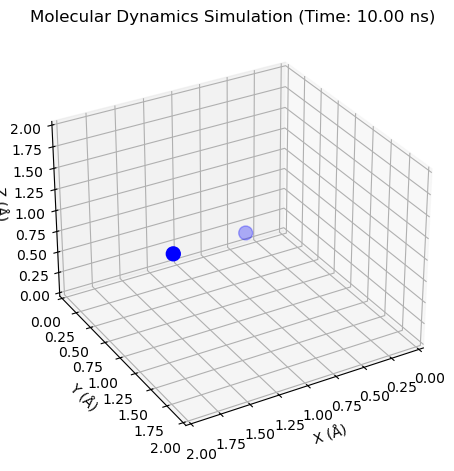

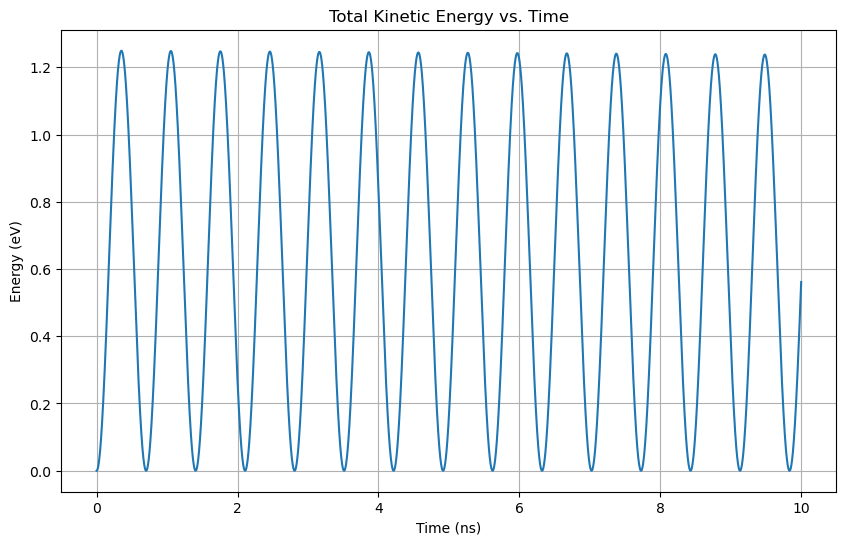

In [3]:
# Parameters
box_size = 2.0  # Units in Å
total_time = 10.0  # Units in ns
total_steps = 100000

# Define atoms
atom1 = Atom(position=np.array([1.0, 1.0, 1.0]), 
             velocity=np.array([0.0, 0.0, 0.0]), 
             mass=1.0, epsilon=1.0, sigma=1.0)

atom2 = Atom(position=np.array([1.5, 1.0, 1.0]), 
             velocity=np.array([0.0, 0.0, 0.0]), 
             mass=1.0, epsilon=1.0, sigma=1.0)
atoms = [atom1, atom2]

# Create spring potential
rest_lengths = {(0, 1): 1.0}
spring_potential = LinearSpringPotential(rest_lengths=rest_lengths, k=10.0)

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms, 
    box_size=box_size, 
    total_time=total_time, 
    total_steps=total_steps, 
    potential=spring_potential
)

# Run simulation
simulator.integrate()
simulator.animate_positions()
simulator.plot_energy()

## Case 2: Three Atoms Under a LJ Potential with Fixed Distance Constraint

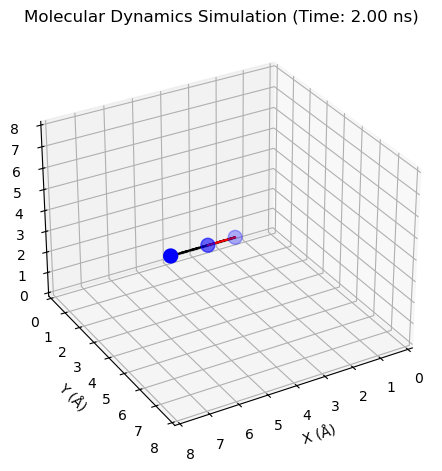

In [5]:
# Parameters
box_size: float = 8.0  # Units in Å
total_time: float = 2.0  # Units in ns
total_steps: int = 2000

# Define atoms
initial_positions: np.ndarray = np.array([
    [2.0, 2.0, 2.0],
    [4.0, 2.0, 2.0],
    [5.0, 2.0, 2.0]
])
initial_velocities: np.ndarray = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
mass: float = 1.0  # Units in AMU
epsilon: float = 4.0  # Units in eV
sigma: float = 1.0  # Units in Å

# Create atom instances
atoms: List[Atom] = [
    Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
    for pos, vel in zip(initial_positions, initial_velocities)
]

# Create LJ potential interaction pairs
pairwise_interactions = {(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)}
lj_potential = LennardJonesPotential(pairwise_interactions=pairwise_interactions)

# Apply fixed distance constraints
fixed_pairs = [(0, 1)]
fixed_distances = {
    (0,1): 1.0,
    (1,0): 1.0
}
fixed_distance_constraint = FixedDistanceConstraint(fixed_distances=fixed_distances)

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms,
    box_size=box_size,
    total_time=total_time,
    total_steps=total_steps,
    potential=lj_potential,
    constraints=[fixed_distance_constraint]
)

# Run simulation
simulator.integrate()
simulator.animate_positions(lj_pairs=pairwise_interactions, fixed_pairs=fixed_pairs)

## Case 3: Monatomic Molecular Dynamics

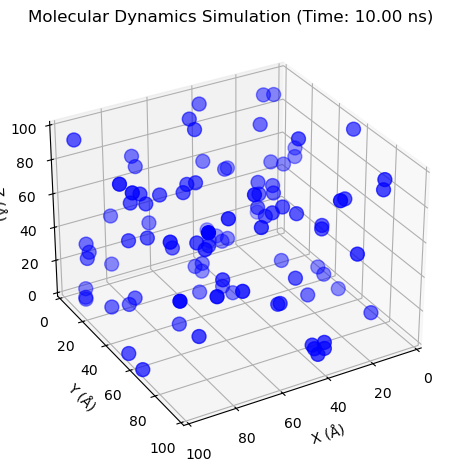

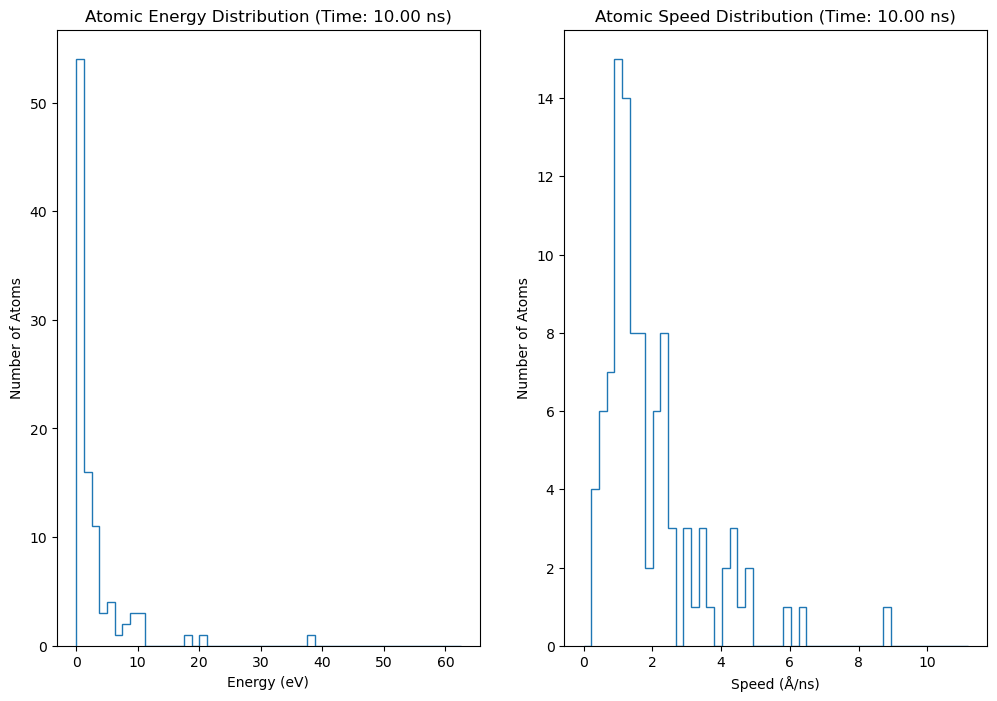

In [7]:
# Parameters
box_size = 100.0  # Units in Å
total_time = 10.0  # Units in ns
total_steps = 1000

# Define atoms
num_atoms = 100
positions = np.random.uniform(0, box_size, (num_atoms, 3))  # Random positions
velocities = np.random.uniform(-1.0, 1.0, (num_atoms, 3))  # Random velocities
mass = 1.0  # Units in AMU
epsilon = 5.0  # Units in eV
sigma = 5.0  # Units in Å

# Create atom instances
atoms = [Atom(position=positions[i], velocity=velocities[i], mass=mass, epsilon=epsilon, sigma=sigma) for i in range(num_atoms)]

# Create LJ potential
lj_potential = LennardJonesPotential()

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms, 
    box_size=box_size, 
    total_time=total_time, 
    total_steps=total_steps, 
    potential=lj_potential
)

# Run the simulation
simulator.integrate()
simulator.animate_positions()
simulator.animate_statistics()

## Case 3: Diatomic Molecular Dynamics

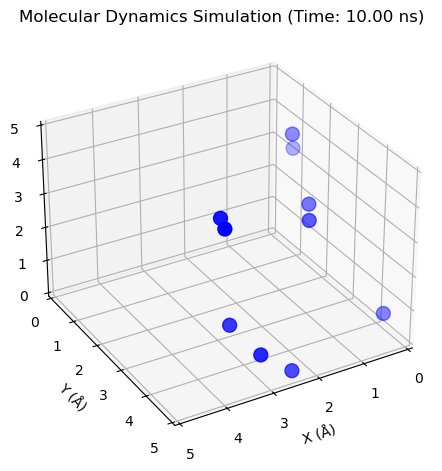

In [9]:
# Parameters
box_size = 5.0  # Units in Å
total_time = 10.0  # Units in ns
total_steps = 1000

# Define atoms
num_atoms = 10
positions = np.random.uniform(0, box_size, (num_atoms, 3))  # Random positions
velocities = np.random.uniform(-0.1, 0.1, (num_atoms, 3))  # Random velocities
mass = 1.0  # Units in AMU
epsilon = 4.0  # Units in eV
sigma = 2.0  # Units in Å

# Create atom instances
atoms = [Atom(position=positions[i], velocity=velocities[i], mass=mass, epsilon=epsilon, sigma=sigma) for i in range(num_atoms)]

# Create LJ potential
lj_potential = LennardJonesPotential()

# Create spring potential
rest_lengths = {
    (0, 1): 1.0,
    (2, 3): 1.0,
    (4, 5): 1.0,
    (6, 7): 1.0,
    (8, 9): 1.0
}
spring_potential = LinearSpringPotential(rest_lengths=rest_lengths, k=10.0)

# Combine the potentials
class CombinedPotential(Potential):
    def __init__(self, lj_potential: LennardJonesPotential, spring_potential: LinearSpringPotential):
        super().__init__()
        self.lj_potential = lj_potential
        self.spring_potential = spring_potential

    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        self.lj_potential.compute_forces(atoms, box_size)
        self.spring_potential.compute_forces(atoms, box_size)

combined_potential = CombinedPotential(lj_potential, spring_potential)

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms,
    box_size=box_size,
    total_time=total_time,
    total_steps=total_steps,
    potential=combined_potential
)

# Run the simulation
simulator.integrate()
simulator.animate_positions()

## Case 4: Beyond Molecular Dynamics, Tensegrity Structure

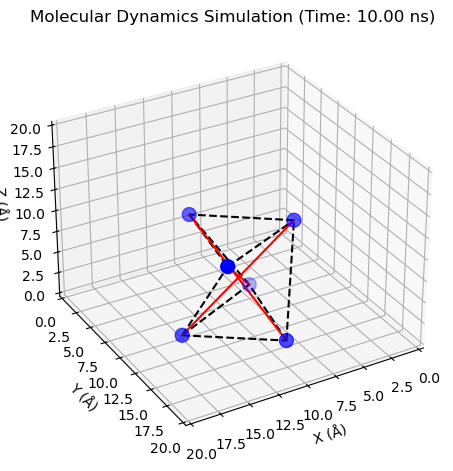

In [11]:
# Parameters
box_size: float = 20.0  # Units in Å
total_time: float = 10.0  # Units in ns
total_steps: int = 1000

# Create atoms
# Geometry
radius: float = 5.0
theta_bottom: float = 0
theta_top: float = np.pi/4
height: float = 10.0
n_polygon: int = 3
side_length: float = radius * 2 * np.sin(np.pi / n_polygon)
initial_positions: np.ndarray = np.array([
    [radius * np.cos(theta_bottom), radius * np.sin(theta_bottom), 0],
    [radius * np.cos(theta_bottom + np.pi * 2 / n_polygon), radius * np.sin(theta_bottom + np.pi * 2 / n_polygon), 0],
    [radius * np.cos(theta_bottom + np.pi * 2 * 2 / n_polygon), radius * np.sin(theta_bottom + np.pi * 2 * 2/ n_polygon), 0],
    [radius * np.cos(theta_top), radius * np.sin(theta_top), height],
    [radius * np.cos(theta_top + np.pi * 2 / n_polygon), radius * np.sin(theta_top + np.pi * 2 / n_polygon), height],
    [radius * np.cos(theta_top + np.pi * 2 * 2 / n_polygon), radius * np.sin(theta_top + np.pi * 2 * 2/ n_polygon), height]
]) + (np.hstack((np.ones([6,2]), np.zeros([6,1])))) * 10
# mountain creases are strings, valley creases are rods
mountain_crease: float = np.linalg.norm(initial_positions[0, :] - initial_positions[n_polygon, :])
valley_crease: float = np.linalg.norm(initial_positions[0, :] - initial_positions[n_polygon + 1, :])
initial_velocities: np.ndarray = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
mass: float = 1.0  # Units in AMU
epsilon: float = 2.0  # Units in eV
sigma: float = 4.0  # Units in Å

# Create Atom instances
atoms: List[Atom] = [
    Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
    for pos, vel in zip(initial_positions, initial_velocities)
]

# LJ potential interaction pairs
lj_pairs = ls_pairs = [
    (0, 1),
    (0, 2), 
    (1, 2), 
    (3, 4),
    (4, 5),
    (5, 3),
    (0, 3),
    (1, 4),
    (2, 5),
]
pairwise_interactions = {(0, 1), (1, 0),
                         (0, 2), (2, 0), 
                         (1, 2), (2, 1), 
                         (3, 4), (4, 3),
                         (4, 5), (5, 4),
                         (5, 3), (3, 5),
                         (0, 3), (3, 0),
                         (1, 4), (4, 1),
                         (2, 5), (5, 2)}
lj_potential = LennardJonesPotential(pairwise_interactions=pairwise_interactions)

# Linear spring potential interaction pairs
ls_pairs = [
    (0, 1), (1, 0),
    (0, 2), (2, 0), 
    (1, 2), (2, 1), 
    (3, 4), (4, 3),
    (4, 5), (5, 4),
    (5, 3), (3, 5),
    (0, 3), (3, 0),
    (1, 4), (4, 1),
    (2, 5), (5, 2)
]
rest_lengths = {
    (0, 1): side_length, (1, 0): side_length,
    (0, 2): side_length, (2, 0): side_length, 
    (1, 2): side_length, (2, 1): side_length, 
    (3, 4): side_length, (4, 3): side_length,
    (4, 5): side_length, (5, 4): side_length,
    (5, 3): side_length, (3, 5): side_length,
    (0, 3): mountain_crease, (3, 0): mountain_crease,
    (1, 4): mountain_crease, (4, 1): mountain_crease,
    (2, 5): mountain_crease, (5, 2): mountain_crease
}
linear_spring_potential = LinearSpringPotential(rest_lengths=rest_lengths, k=2.0)


# Fixed distances
fixed_pairs = [(0, 4),
               (1, 5), 
               (2, 3)]
fixed_distances = {
    (0, 4): valley_crease, (4, 0): valley_crease,
    (1, 5): valley_crease, (5, 1): valley_crease, 
    (2, 3): valley_crease, (3, 2): valley_crease
}
fixed_distance_constraint = FixedDistanceConstraint(fixed_distances=fixed_distances)

# Partial fixed points
partial_fixed_points = {
    1: (None, None, initial_positions[1, 2]),
    2: (None, None, initial_positions[2, 2])
}
partial_fix_constraint = PartialFixConstraint(partial_fixed_points=partial_fixed_points)

# Fixed points constraints
fixed_points = {
    0: initial_positions[0, :]
}
fixed_points_constraint = FixPointConstraint(fixed_points=fixed_points)

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms,
    box_size=box_size,
    total_time=total_time,
    total_steps=total_steps,
    potential=lj_potential,
    constraints=[fixed_distance_constraint, fixed_points_constraint, partial_fix_constraint]
)
# Run simulation
simulator.integrate()
simulator.animate_positions(elev=30, azim=60, lj_pairs=lj_pairs, fixed_pairs=fixed_pairs)